# General setting

In all of the following graphs we use the transition probabilites estimated from group 4 of John Rust's 1987 paper. We stylize the cost parameters to (50, 400), instead if (10, 2.27). The simulation exercises are always with 1000 buses over 100000 periods. For the construction of the uncertainty sets we always use the mean number of observations 4292 / 78.

In [1]:
extract_zips()

# Transition probabilities

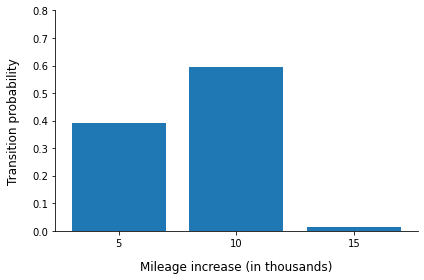

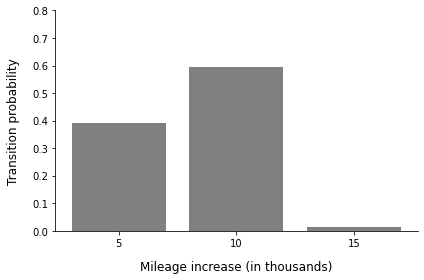

In [2]:
state = 15
get_probabilities(state)

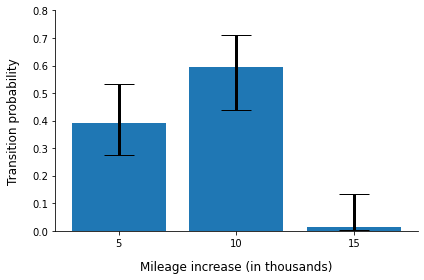

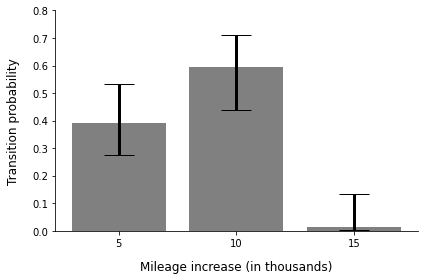

In [3]:
get_probabilities_bar(15)

In [4]:
df_probability_shift(state)

,0,4292_0.50,4292_0.95,2223_0.95
0,0.391892,0.316509,0.239167,0.183433
1,0.595294,0.665851,0.736033,0.784023
2,0.012815,0.017640,0.024800,0.032544


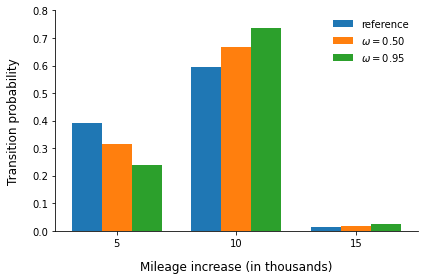

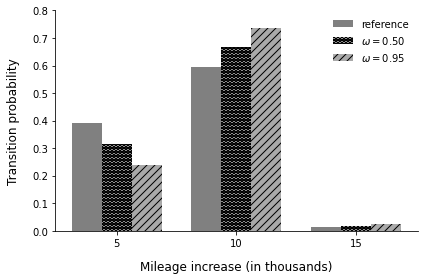

In [5]:
get_probability_shift(state)

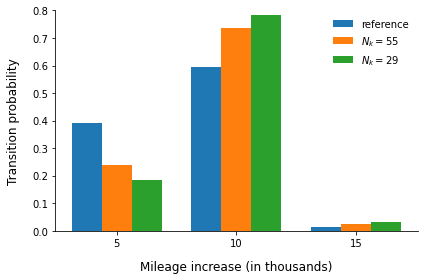

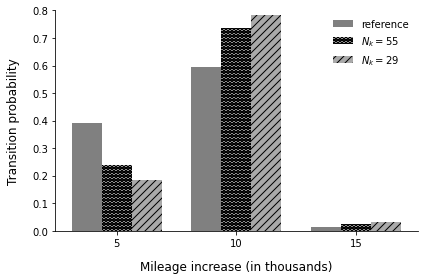

In [6]:
get_probability_shift_data(state)

# Policy Features
 

In [7]:
df_maintenance_probabilties()

,milage_thousands,0.0,0.5,0.95
0,0,1.000000e+00,1.000000e+00,1.000000e+00
1,5,1.000000e+00,1.000000e+00,1.000000e+00
2,10,1.000000e+00,1.000000e+00,1.000000e+00
3,15,1.000000e+00,1.000000e+00,1.000000e+00
4,20,1.000000e+00,1.000000e+00,1.000000e+00
5,25,9.999999e-01,1.000000e+00,1.000000e+00
6,30,9.999923e-01,9.999982e-01,9.999995e-01
7,35,9.995235e-01,9.998875e-01,9.999714e-01
8,40,9.848129e-01,9.960385e-01,9.989383e-01
9,45,7.922063e-01,9.263028e-01,9.767663e-01


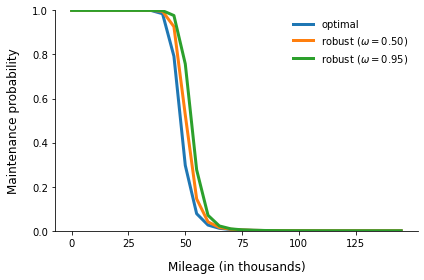

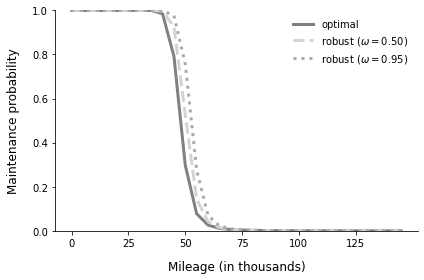

In [8]:
get_maintenance_probabilities()

# Policy performance

In [9]:
max_period = 50

init_dict = {
    "discount_factor": 0.9999,
    "buses": 1,
    "periods": 90,
    "seed": 16,
}

df = get_demonstration_df(init_dict)
df

,months_ml,months_rob,opt_mileage,rob_mileage
0,0,0,0,0
1,1,1,5,5
2,2,2,5,5
3,3,3,5,5
4,4,4,5,5
...,...,...,...,...
90,85,86,15,50
91,86,87,20,55
92,87,88,25,60
93,88,88,30,0


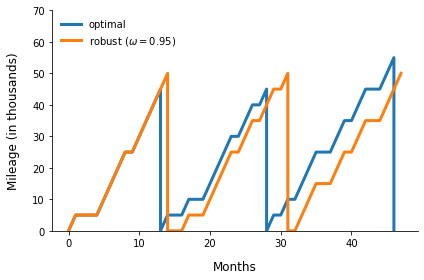

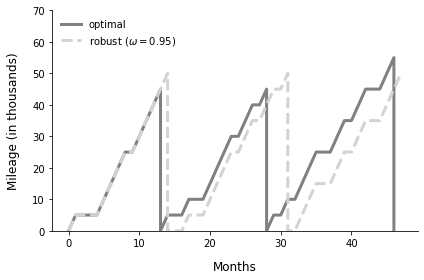

In [10]:
get_demonstration(df, max_period)

In [11]:
df_thresholds()

,omega,threshold
0,0.00,12
1,0.01,12
2,0.02,12
3,0.03,12
4,0.04,12
...,...,...
95,0.95,14
96,0.96,14
97,0.97,14
98,0.98,14


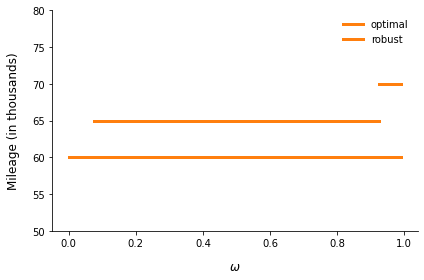

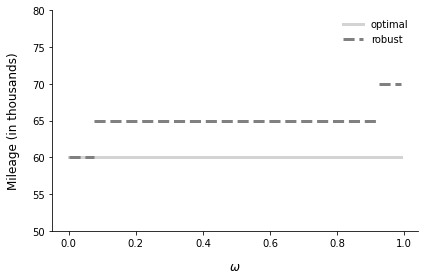

In [12]:
get_replacement_thresholds()

In [13]:
get_decision_rule_df()

,months,disc_strategy,exp_value
0,0,0.000000,-46981.263988
1,1000,-5051.336957,-46981.263988
2,2000,-9653.143746,-46981.263988
3,3000,-13812.102103,-46981.263988
4,4000,-17579.902280,-46981.263988
...,...,...,...
96,96000,-53390.028609,-46981.263988
97,97000,-53390.372477,-46981.263988
98,98000,-53390.683862,-46981.263988
99,99000,-53390.965687,-46981.263988


The underlying transition matrix is the worst case given omega=0.95


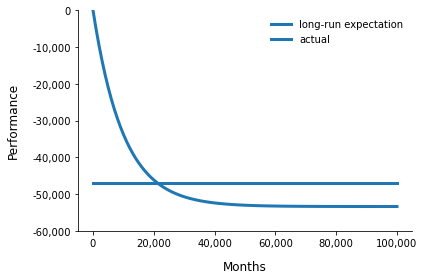

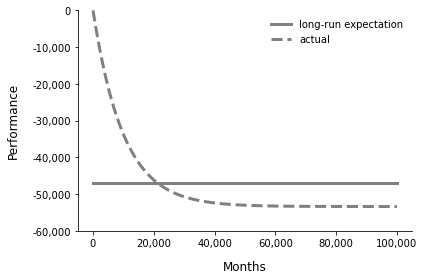

In [14]:
get_performance_decision_rules()

In [15]:
df = get_difference_df()

The dataframe contains the difference for robust - nominal strategy.


In [16]:
df[df["omega"] == 0.01]

,omega,robust_95,robust_050
1,0.01,-217.647618,-43.718758


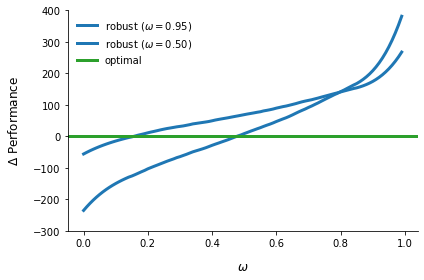

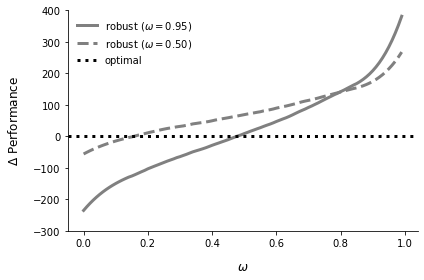

In [17]:
get_difference_plot()